In [ ]:
import re
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge
from sklearn.feature_extraction.text import CountVectorizer
from transformers import AutoProcessor
from datasets import load_dataset
from transformers import AutoModelForVision2Seq, AutoProcessor
import torch
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from transformers import AutoProcessor, LlavaForConditionalGeneration
from qwen_vl_utils import process_vision_info
import json
import os
from PIL import Image
from matplotlib import pyplot as plt
from transformers import AutoModelForCausalLM, AutoProcessor

/root/miniforge3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-20 18:37:28.652335: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-20 18:37:29.298501: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-20 18:37:29.298605: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-20 18:37:29.406838: E exte

In [4]:
#第一次跑的是时候需要运行
# ! pip install tiktoken
# ! pip install blobfile

In [4]:
model_id = "llava-hf/llava-1.5-7b-hf"
model = LlavaForConditionalGeneration.from_pretrained(
    model_id, 
    torch_dtype=torch.float16, 
    low_cpu_mem_usage=True, 
).to(0)

processor = AutoProcessor.from_pretrained(model_id)


Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00,  6.39it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [5]:
with open("split_result/test_zeroshot.jsonl", 'r') as fr:
  arxiv_qa = [ json.loads(line.strip()) for line in fr]
  
test_dataset = []
for i in range(len(arxiv_qa)):
    sample = arxiv_qa[i]
    try:
        if sample['question'] is None:
            print(f"第 {i} 个样本没有问题，跳过")
            continue

        test_dataset.append({
            'id':sample['id'],
            "image": sample['image'], 
            "question": sample["question"],
            "choices": sample["options"],
            "answer": sample["label"],
            "solution": sample["rationale"]
        })
    except Exception as e:
        print(f"跳过第 {i} 个样本，错误：{e}")
        continue

In [6]:
def build_message(sample):
    content = []
    if sample['image'] is not None:
        content.append({"type": "image", "image": "/root/IC_MLLM_VQA/ArxivQA/images/"+sample['image']}) #绝对路径
    
    question_text = f"Question: {sample['question']}\nChoices:\n"
    for idx, choice in enumerate(sample['choices']):
        question_text += f"{chr(65 + idx)}. {choice}\n"
    
    question_text += "Read the image carfelly and please select the correct answer and explain why."
    content.append({"type": "text", "text": question_text})
    
    return [{"role": "user", "content": content}]

[{'role': 'user', 'content': [{'type': 'image', 'image': '/root/IC_MLLM_VQA/ArxivQA/images/images/1802.04661_1.jpg'}, {'type': 'text', 'text': 'Question: What is the relationship shown in panel (d)?\nChoices:\nA. A. The correlation between Terfenol-D position offset and its magnetic field strength.\nB. B. The impact of Terfenol-D position offset on the electrical conductivity of the system.\nC. C. The frequency response of a system to changes in Terfenol-D position.\nD. D. The relationship between Terfenol-D position offset and the effective capacitance.\nRead the image carfelly and please select the correct answer and explain why.'}]}]


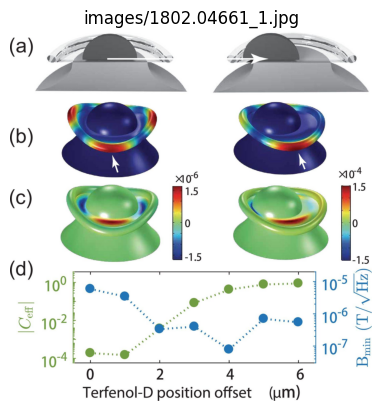

In [7]:
from torchvision import transforms
for sample in test_dataset:
    messages = build_message(sample)
    image_path = '/root/IC_MLLM_VQA/ArxivQA/images/'+sample["image"]
    image_inputs = Image.open(image_path).convert("RGB")
    break
print (messages)
plt.imshow(image_inputs)
plt.axis("off")
plt.title(sample["image"])
plt.show()

In [8]:
# 映射选项
answer_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3,'E': 4}

# 提取选项字母的函数（支持 C、c、C.、C) 等）
def extract_choice_letter(ans):
    if not isinstance(ans, str):
        return None
    ans = ans.strip()
    match = re.match(r"([A-Da-d])[\.\)]?", ans)
    return match.group(1).upper() if match else None

# 构建模型输入消息
def build_message(sample):
    content = []
    if sample['image'] is not None:
        content.append({"type": "image", "image": sample['image']})
    question_text = f"Question: {sample['question']}\nChoices:\n"
    for idx, choice in enumerate(sample['choices']):
        question_text += f"{chr(65 + idx)}. {choice}\n"
    question_text += "Please select the correct answer and explain why."
    content.append({"type": "text", "text": question_text})
    return [{"role": "user", "content": content}]

# 解析模型输出（返回编号+解释）
def parse_output(output):
    output = output.strip()
    answer_match = re.search(r"\b([A-Da-d])[\.\:\)]?", output)
    answer_letter = answer_match.group(1).upper() if answer_match else None
    answer = answer_mapping.get(answer_letter, -1)
    explanation = ""
    if answer != -1:
        idx = output.find(answer_match.group(0))
        if idx != -1:
            explanation = output[idx + len(answer_match.group(0)):].strip()
    return answer, explanation

# 初始化评估工具
rouge = Rouge()
smoothie = SmoothingFunction().method1
vectorizer = CountVectorizer(stop_words="english").fit([s["solution"] for s in test_dataset])
keywords = set(vectorizer.get_feature_names_out())

# 记录结果
all_records = []

for idx, sample in enumerate(tqdm(test_dataset, desc="Evaluating", ncols=100, leave=False)):
    # 构建输入
    messages = build_message(sample)
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_path = '/root/IC_MLLM_VQA/ArxivQA/images/' + sample["image"]
    image_inputs = Image.open(image_path).convert("RGB")

    inputs = processor(text=[text], images=image_inputs, return_tensors="pt", padding=True).to("cuda")
    generated_ids = model.generate(**inputs, max_new_tokens=512)
    output = processor.batch_decode(generated_ids[:, inputs.input_ids.shape[-1]:], skip_special_tokens=True)[0]

    # 解析模型输出
    pred_answer_id, pred_explanation = parse_output(output)

    # 计算 BLEU
    if pred_explanation:
        bleu = sentence_bleu([sample["solution"].split()], pred_explanation.split(), smoothing_function=smoothie)
    else:
        bleu = 0.0

    # 计算 ROUGE-L
    try:
        rouge_score = rouge.get_scores(pred_explanation, sample["solution"])[0]["rouge-l"]["f"]
    except:
        rouge_score = 0.0

    # 计算关键词重叠
    gt_tokens = set(sample["solution"].lower().split())
    pred_tokens = set(pred_explanation.lower().split())
    overlap = len(gt_tokens & pred_tokens & keywords)
    keyword_score = overlap / max(len(gt_tokens & keywords), 1)

    # 提取真实答案
    true_letter = extract_choice_letter(sample["answer"])
    true_answer_id = answer_mapping.get(true_letter, -1)

    # 存入结果
    all_records.append({
        "Question": sample["question"],
        "Choices": "\n".join(sample["choices"]),
        "True Answer": sample["answer"],
        "True Answer ID": true_answer_id,
        "Predicted Answer ID": pred_answer_id,
        "Correct": int(true_answer_id == pred_answer_id),
        "Model Output": output,
        "Model Explanation": pred_explanation,
        "Reference Solution": sample["solution"],
        "BLEU": bleu,
        "ROUGE-L": rouge_score,
        "Keyword Overlap": keyword_score
    })

# 构建结果表格
results_df = pd.DataFrame(all_records)
results_df.to_csv("ArxivQA_testing_physics.csv", index=False, encoding="utf-8-sig")

# 汇总指标（基于编号比较准确率）
acc = accuracy_score(results_df["True Answer ID"], results_df["Predicted Answer ID"])
f1 = f1_score(results_df["True Answer ID"], results_df["Predicted Answer ID"], average='macro')
avg_bleu = results_df["BLEU"].mean()
avg_rouge = results_df["ROUGE-L"].mean()
avg_keyword_overlap = results_df["Keyword Overlap"].mean()

# 打印汇总结果
print("\n📊 Summary Metrics:")
print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print(f"✅ Avg BLEU: {avg_bleu:.4f}")
print(f"✅ Avg ROUGE-L: {avg_rouge:.4f}")
print(f"✅ Avg Keyword Overlap: {avg_keyword_overlap:.4f}")
print("\n📁 结果已保存为 ArxivQA_testing_physics.csv（UTF-8 with BOM）")




📊 Summary Metrics:
✅ Accuracy: 0.4420
✅ F1 Score: 0.3339
✅ Avg BLEU: 0.0496
✅ Avg ROUGE-L: 0.2703
✅ Avg Keyword Overlap: 0.2742

📁 结果已保存为 ArxivQA_testing_physics.csv（UTF-8 with BOM）
